In [2]:
import itertools

import torch
import torch.optim as optim
from allennlp.data.dataset_readers.seq2seq import Seq2SeqDatasetReader
from allennlp.data.iterators import BucketIterator
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.data.vocabulary import Vocabulary
from allennlp.nn.activations import Activation
from allennlp.models.encoder_decoders.simple_seq2seq import SimpleSeq2Seq
from allennlp.modules.attention import LinearAttention, BilinearAttention, DotProductAttention
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper, StackedSelfAttentionEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.predictors import Seq2SeqPredictor
from allennlp.training.trainer import Trainer
from allennlp.data.dataset_readers.stanford_sentiment_tree_bank import StanfordSentimentTreeBankDatasetReader
import hashlib
from luna import auto_create, load_var, log, log_config
import pathlib
from allennlp.modules.token_embedders import Embedding, TokenEmbedder
from allennlp.modules.token_embedders.embedding import \
    _read_pretrained_embeddings_file
from sst_model import LstmClassifier
from allennlpx import allenutil
from allennlpx.predictors.text_classifier import TextClassifierPredictor
from allennlp.modules.seq2seq_decoders import AutoRegressiveSeqDecoder, LstmCellDecoderNet
from allennlp.modules.seq2seq_encoders import StackedBidirectionalLstm
from allennlp.models import ComposedSeq2Seq
from luna import load_model
from luna import chunks

In [3]:
sub_reader = StanfordSentimentTreeBankDatasetReader(token_indexers={"tokens": SingleIdTokenIndexer(lowercase_tokens=True)},
                                                    granularity='2-class',
                                                    use_subtrees=True)
reader = StanfordSentimentTreeBankDatasetReader(token_indexers={"tokens": SingleIdTokenIndexer(lowercase_tokens=True)},
                                                granularity='2-class')


def load_data():
    sub_train_data = sub_reader.read(
        'https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/train.txt')
    train_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/train.txt')
    dev_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/dev.txt')
    test_data = reader.read('https://s3-us-west-2.amazonaws.com/allennlp/datasets/sst/test.txt')
    return sub_train_data, train_data, dev_data, test_data

sub_train_data, train_data, dev_data, test_data = auto_create("sst_data", load_data, True)

vocab=load_var("sst_vocab")
sst_clf = LstmClassifier(vocab, pretrain="fasttext")
load_model(sst_clf, "sst_model")
sst_predictor = TextClassifierPredictor(sst_clf, reader)
sst_clf.eval()

cache for sst_data exists
*** load sst_data from cache cost 3.48 seconds
cache for 1f6255ebb41db9818f808b914b264246 exists
*** load 1f6255ebb41db9818f808b914b264246 from cache cost 0.0424 seconds
Restore model from checkpoint saved/models/sst_model@0.ckpt.


LstmClassifier(
  (word_embedders): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (encoder): PytorchSeq2VecWrapper(
    (_module): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=2, bias=True)
  )
  (loss_function): CrossEntropyLoss()
)

In [4]:
with torch.no_grad():
    sent_embeds = []
    sent_preds = []
    sent_labels = []
    for instances in chunks(train_data, 500):
        with sst_predictor.capture_model_internals() as internals:
            outputs = sst_predictor.predict_batch_instance(instances)
        for k in internals.keys():
            if "PytorchSeq2VecWrapper" in internals[k]['name']:
                sent_embeds.append(internals[k]['output'])
        for i, ele in enumerate(outputs):
            sent_preds.append(ele['probs'][vocab.get_token_index('0', 'labels')] > ele['probs'][vocab.get_token_index('1', 'labels')])
        for instance in instances:
            sent_labels.append(instance.fields['label'].label == '0')
    sent_embeds = torch.cat(sent_embeds, dim=0)



Encountered the loss key in the model's return dictionary which couldn't be split by the batch size. Key will be ignored.


In [9]:
import numpy as np
from sklearn.manifold import TSNE
# from tsnecuda import TSNE
# X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X)
X = sent_embeds.cpu().numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(6920, 2)

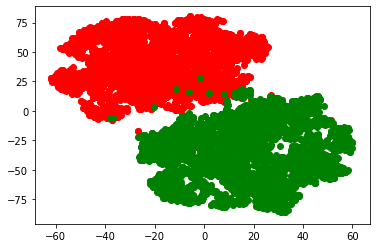

In [113]:
from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0][np.array(sent_labels)], X_embedded[:, 1][np.array(sent_labels)], c='r')
plt.scatter(X_embedded[:, 0][~np.array(sent_labels)], X_embedded[:, 1][~np.array(sent_labels)], c='g')

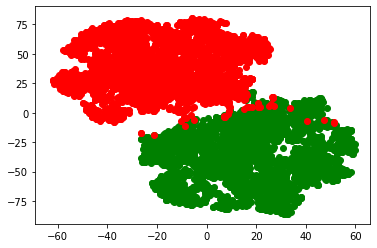

In [114]:
plt.scatter(X_embedded[:, 0][~np.array(sent_preds)], X_embedded[:, 1][~np.array(sent_preds)], c='g')
plt.scatter(X_embedded[:, 0][np.array(sent_preds)], X_embedded[:, 1][np.array(sent_preds)], c='r')

In [101]:
total_num = 0
succ_num = 0
for i in range(len(X_embedded)):
    if -3 < X_embedded[i][0] < 3:
        label = test_data[i].fields['label'].label == '0'
        total_num += 1
        if label == sent_preds[i]:
            succ_num += 1
            
#         print(i)
#         print(allenutil.as_sentence(test_data[i]))
#         print('label: ', label)
#         print('pred:  ', sent_preds[i])
        
print(succ_num, total_num, succ_num/total_num)
            

33 78 0.4230769230769231


In [96]:
vocab.get_token_index('1', 'labels')

0